### Bayesian Mixture of Gaussians

### GMM Model

<img src='VBGMM.png' width=500>

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.stats import wishart
%matplotlib inline

### Toy Data Generation

In [2]:
np.random.seed(42)

# Define number of dimensions 
D = 2
# Define number of clusters
H = 4
# Generate the cluster centers
mus = rnd.multivariate_normal(np.zeros(D),100*np.eye(D),size=H)
mus

array([[ 4.96714153, -1.38264301],
       [ 6.47688538, 15.23029856],
       [-2.34153375, -2.34136957],
       [15.79212816,  7.67434729]])

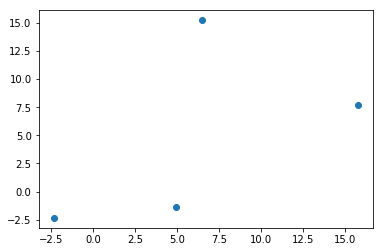

In [3]:
_=plt.plot(*mus.T,'o')

In [4]:
# Draw covariance matrices for the clusters
LAMBDAS = wishart.rvs(2*D, 0.5*np.eye(D), size=H)
LAMBDAS.shape

(4, 2, 2)

In [5]:
X = []; L = []
N = 100
for h in range(H):
    x_h = rnd.multivariate_normal(mus[h], la.inv(LAMBDAS[h]), size = N)
    X += list(x_h)
    L += list(h*np.ones(N))
X = np.array(X)
L = np.array(L)

In [6]:
#np.save('X',X)
#np.save('L',L)
#X = np.load('X.npy')
#L = np.load('L.npy')

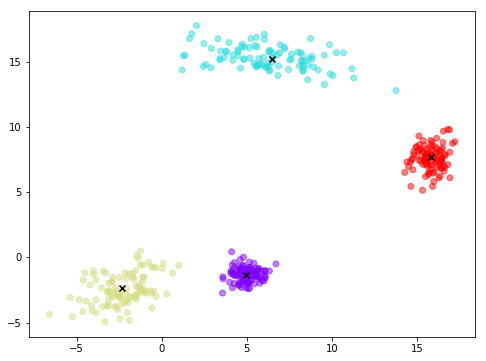

In [7]:
from matplotlib import cm
plt.figure(figsize=(8,6))
plt.scatter(*X.T,c=L,cmap=cm.rainbow,alpha=0.5)
_=plt.scatter(*mus.T,c='k',marker='x',linewidths=25)

<hr>

#### Prior for cluster proportions
<br>
<center>
    $\large{
    p(\boldsymbol \pi) = \mathcal{Dir}(\boldsymbol \pi | \alpha_0) = \mathcal{C}(\alpha_0) \prod_{k=1}^K \boldsymbol{\pi}_k^{\alpha_0 - 1}
    }$
    <br><br>
    $\large{
    \quad \mathcal{C}(\alpha_0) = \frac{\Gamma({K\alpha_0})}{K \Gamma(\alpha_0)}, \quad
        \Gamma(z) =  \int_0^{\infty} x^{z-1}e^{-x}dx
    }$

#### Prior cluster responsibilities
<br>
<center>
    $\large{p(\mathbf Z|\boldsymbol\pi) = \prod_{n=1}^N\prod_{k=1}^K \boldsymbol{\pi}_k^{z_{nk}}}$

#### Gauss-Wishart prior for cluster means and precision matrices
<br>
<center>
    $\large{
    p(\boldsymbol \mu,\boldsymbol\Lambda) = p(\boldsymbol\mu|\boldsymbol\Lambda)p(\boldsymbol\Lambda) =
    \prod_{k=1}^K \mathcal{N}(\mu_k | m_0, (\beta_0 \Lambda_k)^{-1})\mathcal{W}(\Lambda_k| W_0, \nu_0)
    }$

#### Conditional distributions for the observeda datapoints

<br>
<center>
    $\large{
    p(\mathbf X | \mathbf Z, \boldsymbol \mu, \boldsymbol \Lambda) = \prod_{n=1}^N\prod_{k=1}^K \mathcal{N}( x_n | \mu_k, \Lambda_k^{-1})^{z_{nk}}
    }$

### Initialize variables and hyper parameters

In [8]:
# Number of points
N = X.shape[0]
# Dimensionaly of the Data
D = X.shape[1]
# Starting number of clusters
K = 20

# Wishart degree of freedom
v_0 = D + 1
v_ = v_0 * np.ones(K)

# Wishart covariance matrix only diagonal elements
W_0 = 10*np.eye(D)
W_ = np.ones((K,D,D)) * W_0[None]
W_0_inv = la.inv(W_0)

# Init prior cluster proportions hyperparameter
phi_0 = 1 # D + D*(D + 1)/2
alpha_0 = phi_0*np.ones(K)

# cluster responsibilieties (soft assignments)
resp = np.ones((N,K))/K

# Initialize cluster means

beta_0 = 0.1
m_0 = np.random.normal(0,1,size = (K,D))

#### Log-Sum-Exp Trick
<br>
<center>
    $\large{
    \ln \sum_{i=1}^N \exp{(x_i)} = a + \ln\sum_{i=1}^N \exp{(x_i - a)}, \quad \text{where} \quad a = max(x_1,...,x_n)
    }$
 

#### Update cluster responsibilities
<br>
<center>
    $
\boxed{\large{ \ln \rho_{nk} = \mathbb{E}\Big[\ln \pi_k\Big] + \frac{1}{2}\Big(\mathbb{E}\Big[\ln|\Lambda_k|\Big] - D\ln(2\pi)
- \mathbb{E}\Big[ (x_n - \mu_k)^{\top} \Lambda_k (x_n - \mu_k)\Big]\Big) = \omega_{nk}}}
$
<br><br><br>
    $\large{
    r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^K \rho_{nj}}, \quad \ln{r_{nk}} = \ln \rho_{nk} - \ln \sum_{j=1}^K \exp{(\ln\rho_{nj})}}
    $
<br><br>
$\large{
\ln r_{nk} = \omega_{nk} - \ln \sum_{j=1}^K \exp{(\omega_{nk})}}
$
<br><br>
<hr>

In [9]:
from scipy.special import logsumexp
def update_resp():
    """
    Update responsibilities. Bishop page 477 (10.49)
    """
    omega = E_ln_pi + 0.5*(E_ln_det_Lambda - D*np.log(2*np.pi) - E_mu_Lambda) # N,K
    #             N,K         N,1
    return np.exp(omega - logsumexp(omega,1)[:,None]) # N,K

###  Soft number of cluster elements
<br>
<center>
    $\boxed{\large{N_k = \sum_{n=1}^{N}r_{nk}}} $

In [10]:
def comp_N_():
    """
    Bishop page 477 (10.51)
    """
    return resp.sum(0)
#N_ = comp_N_()
#N_

###  Soft cluster means 
<center>
$ \boxed{\large{\overline{x}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} \mathbf{x}_n}}$

In [11]:
def comp_X_():
    """
    Bishop page 477 (10.52)
    """
    #       N,K,1   N,1,D ->           (K,D)    (K,1)  
    return (resp[:,:,None] * X[:,None]).sum(0)/N_[:,None] 
#X_ = comp_X_()
#X_.shape

### Soft cluster covariance matrices
<br>
<center>
$\boxed{\large{
\mathbf{S}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk}(x_n - \overline{x}_k)(x_n - \overline{x}_k)^{\top}}}$

In [12]:
def outer_prod(arr1, arr2):
    res = np.zeros((arr1.shape[0], arr1.shape[1], arr1.shape[2], arr1.shape[2]))
    for i in range(arr1.shape[0]):
        for j in range(arr1.shape[1]):
            res[i, j] = np.outer(arr1[i, j], arr2[i, j])
    return res

In [13]:
def comp_S_():
    """
    Bishop page 477 (10.53)
    """
    #       N,1,D             1,K,D
    _sub = X[:, None] - X_[None]
    #           N,K,1,1                N,K,D,D
    _outer = resp[:, :, None, None] * outer_prod(_sub, _sub)
    #             K,D,D             K,1,1
    return np.sum(_outer, axis=0) / N_[:, None, None] # K,D,D

#S_ = comp_S_()
#S_.shape

### Update cluster proportions variatonal parameter
<br>
<center>
    $
    \boxed{\large{\alpha_k = \alpha_0 + N_k}}
    $

In [14]:
def update_alpha_():
    """
    Bishop page 478 (10.58)
    """
    return alpha_0 + N_

#alpha_ = update_alpha_()
#alpha_, alpha_0

#### Update variational precision factor

<center>
    $\boxed{\large{
    \beta_k = \beta_0 + N_k
    }}$

In [15]:
def update_beta_():
    """
    Bishop page 478 (10.60)
    """
    return N_ + beta_0
#beta_ = update_beta_()
#beta_

#### Update variational mean 
<br>
<center>
    $\boxed{\large{
    m_k = \frac{1}{\beta_k}(\beta_0 m_0 + N_k \hat{x}_k)
    }}$
    

In [16]:
def update_m_():
    """
    Bishop page 478 (10.61)
    """
    return (beta_0*m_0 + N_[:, None] * X_) / beta_[:, None]

#m = update_m_()
#m

#### Update variational precision matrix
<br>
<center>
    $\boxed{\large{
    W_k^{-1} = W_0^{-1} + N_kS_k + \frac{\beta_0N_k}{\beta_0 + N_k}(\overline{x}_k - m_0)(\overline{x}_k - m_0)^{\top}
    }}$

In [17]:
def outer_product(arr1, arr2):
    res = np.zeros((arr1.shape[0], arr1.shape[1], arr1.shape[1]))
    for i in range(arr1.shape[0]):
        res[i] = np.outer(arr1[i], arr2[i])
    return res

In [18]:
def update_W_():
    """
    Bishop page 478 (10.62)
    """
    #           K,D                 K,D
    _sub = np.subtract(X_, m_0)
    _outer = outer_product(_sub, _sub) # K,D,D
    _NS_prod = N_[:, None, None] * S_ # K,D,D
    _division = (beta_0 * N_)/(beta_0 + N_)
    return la.inv(W_0_inv[None] + (_NS_prod + (_division[:, None,None] * _outer)))

#W_ = update_W_()
#W_.shape

#### Update variational degree of freedom
<br>
<center>
    $\boxed{\large{
    \nu_k = \nu_0 + N_k + 1
    }}$

In [19]:
def update_v_():
    """
    Bishop page 478 (10.63)
    """
    return v_0 + N_ + 1

#v_ = update_v_()

#### Expected log determinant of the precision matrix
<br>
<center>
    $\large{
    \mathbb{E}\Big[\ln|\Lambda_k|\Big] = \sum_{i=1}^D\psi\Big( \frac{\nu_k + 1 - i}{2}\Big) + D\ln{2} + \ln|W_k|}
    $

In [20]:
from scipy.special import digamma
def comp_E_ln_det_Lambda():
    """
    Bishop page 478 (10.65)
    """
    sgn, vals = np.linalg.slogdet(W_)
    res = sgn*vals
    _dln_logdet_sum = D*np.log(2) + res
    _digamma_sum = np.sum(digamma((v_[:, None] - np.arange(1, D+1)[None] + 1) * 0.5), axis=1)
    return _digamma_sum + _dln_logdet_sum

#E_ln_det_Lambda = comp_E_ln_det_Lambda()
#E_ln_det_Lambda

#### Expected log of cluster proportions
<br>
<center>
$\boxed{\large{
\mathbb{E}\Big[ \ln \pi_k \Big] = \psi{(\alpha_k)} - \psi{(\hat{\alpha})}}, 
\quad \psi(x) = \frac{d}{dx}\ln{(\Gamma(x))}}
$

In [21]:
def comp_E_ln_pi():
    """
    Bishop page 478 (10.66)
    """
    return digamma(alpha_) - digamma(alpha_.sum())

#E_ln_pi = comp_E_ln_pi()

#### Expected mu Lambda product
<br>
<center>
    $\boxed{\large{
    \mathbb{E}\Big[ (x_n - \mu_k)^{\top}\Lambda_k(x_n - \mu_k) \Big] = D\beta_k^{-1} + \nu_k(x_n - m_k)^{\top}W_k(x_n - m_k)
    }}$

In [22]:
def xnmTWxnm_vec_dot(X, W_, mu):
    res = np.zeros((X.shape[0], mu.shape[0]))
    _sub = np.subtract(X[:, None], mu[None])
    for p in range(res.shape[0]):
        for k in range(res.shape[1]):
            _dot1 = np.dot(W_[k], _sub[p, k])
            _dot2 = np.dot(_sub[p, k].T, _dot1)
            res[p, k] = _dot2
    return res

In [23]:
def comp_E_mu_Lambda():
    """
    Bishop page 478 (10.64)
    """
    _dot = xnmTWxnm_vec_dot(X, W_, m)
    _mult = v_ * _dot
    return  D/beta_ + _mult

In [32]:
from tqdm import tqdm
n_max = 500
for i in tqdm(range(n_max)):
    # compute statistics
    N_ = comp_N_()
    X_ = comp_X_()
    S_ = comp_S_()

    # Update variational parameters
    alpha_ = update_alpha_()
    beta_ = update_beta_()
    m = update_m_()
    W_ = update_W_()
    v_= update_v_()

    # compute required expectations
    E_ln_det_Lambda = comp_E_ln_det_Lambda()
    E_ln_pi = comp_E_ln_pi()
    E_mu_Lambda = comp_E_mu_Lambda()

    # update cluster responsibilities
    resp = update_resp()

100%|██████████| 500/500 [00:23<00:00, 21.59it/s]


In [33]:
cnv = lambda x: f" {x:0.2f}"
[ f' {i+1} : {cnv(n)}' for i,n in enumerate(N_)]

[' 1 :  8.79',
 ' 2 :  0.00',
 ' 3 :  0.00',
 ' 4 :  100.00',
 ' 5 :  0.00',
 ' 6 :  0.00',
 ' 7 :  0.00',
 ' 8 :  0.00',
 ' 9 :  0.00',
 ' 10 :  100.00',
 ' 11 :  84.36',
 ' 12 :  5.70',
 ' 13 :  0.00',
 ' 14 :  0.00',
 ' 15 :  0.00',
 ' 16 :  0.00',
 ' 17 :  100.00',
 ' 18 :  0.00',
 ' 19 :  1.15',
 ' 20 :  0.00']

In [34]:
m

array([[-1.67512592, -0.86090469],
       [-1.3444589 , -0.91864784],
       [-1.00415473, -0.76776669],
       [ 4.99083697, -1.32009253],
       [ 1.5505004 , -0.99835398],
       [ 0.98432318, -0.21400152],
       [-0.04946371,  0.67481949],
       [-1.12304476,  0.38267265],
       [ 0.16645221,  0.49245126],
       [ 6.25121051, 15.31068039],
       [-2.31648867, -2.57505015],
       [-1.32762699, -2.57448305],
       [-0.63738713,  1.18901653],
       [ 1.42049169, -0.57074803],
       [-0.83241531,  0.4714188 ],
       [-0.55222319,  0.63293179],
       [15.78608516,  7.60665057],
       [ 1.5475052 ,  1.79587767],
       [-5.8161475 , -3.858379  ],
       [ 0.28586539,  0.33445679]])

In [35]:
c_mean = m[N_ > 5]
c_mean, N_[N_ > 5]

(array([[-1.67512592, -0.86090469],
        [ 4.99083697, -1.32009253],
        [ 6.25121051, 15.31068039],
        [-2.31648867, -2.57505015],
        [-1.32762699, -2.57448305],
        [15.78608516,  7.60665057]]),
 array([  8.78789142,  99.99916487, 100.00000001,  84.36239741,
          5.69890251,  99.99999999]))

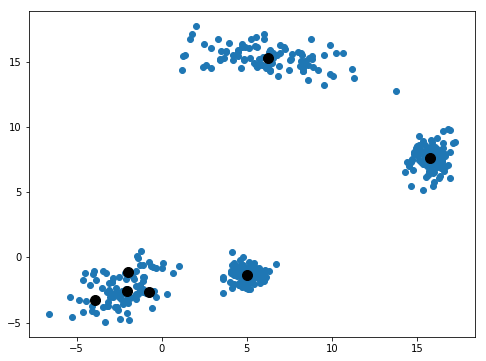

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(*X.T)
_=plt.plot(*c_mean.T,'ko',ms=10)